In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import GOSTnets.calculate_od_raw as calcOD
from GOSTnets.load_osm import *
import rasterio as rio
from osgeo import gdal
import numpy as np
from shapely.geometry import Point

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

%load_ext autoreload
%autoreload 2

In [5]:
import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterstats import zonal_stats
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from infrasap import rasterMisc

In [3]:
country = 'zimbabwe'
iso3 = 'ZWE'
epsg = 32736

In [4]:
base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")

base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

In [6]:
targets_rio = rio.open("/home/wb514197/data/ENERGY/targets.tif")  # from GRIDFINDER Paper
# targets = targets_rio.read(1)

In [34]:
wp_100m = rio.open(os.path.join(out_folder, "zwe_ppp_2020_UNadj.tif"))
wp_arr = wp_100m.read(1, masked=True)
pop_fb = rio.open(os.path.join(out_folder, "population_zwe_2019-07-01.tif"))
fb_arr = pop_fb.read(1, masked=True)

In [12]:
wp_arr.shape

(8170, 9383)

In [35]:
fb_arr.shape

(24320, 28160)

In [16]:
rasterMisc.standardizeInputRasters(targets_rio, wp_100m, os.path.join(out_folder, "energy", "targets_ZWE_wp.tif"), data_type='C')
rasterMisc.standardizeInputRasters(targets_rio, pop_fb, os.path.join(out_folder, "energy", "targets_ZWE_fb.tif"), data_type='C')

In [17]:
targets_fb = rio.open(os.path.join(out_folder, "energy", "targets_ZWE_fb.tif"))
targets_fb_arr = targets_fb.read(1)
targets_wp = rio.open(os.path.join(out_folder, "energy", "targets_ZWE_wp.tif"))
targets_wp_arr = targets_wp.read(1)

In [19]:
targets_wp.shape == wp_100m.shape

True

In [20]:
targets_fb.shape == pop_fb.shape

True

In [38]:
intersect_wp = targets_wp_arr*wp_arr
intersect_fb = targets_fb_arr*fb_arr

In [22]:
admin = gpd.read_file(focal_admin2)

In [25]:
zs_sum_wp = pd.DataFrame(zonal_stats(admin, wp_arr, affine=wp_100m.transform, stats='sum', nodata=wp_100m.nodata)).rename(columns={'sum':'pop_wp'})
zs_electrified_wp = pd.DataFrame(zonal_stats(admin, intersect_wp, affine=wp_100m.transform, stats='sum', nodata=wp_100m.nodata)).rename(columns={'sum':'pop_electrified_wp'})

In [40]:
zs_sum_fb = pd.DataFrame(zonal_stats(admin, fb_arr, affine=pop_fb.transform, stats='sum', nodata=pop_fb.nodata)).rename(columns={'sum':'pop_fb'})
zs_electrified_fb = pd.DataFrame(zonal_stats(admin, intersect_fb, affine=pop_fb.transform, stats='sum', nodata=pop_fb.nodata)).rename(columns={'sum':'pop_electrified_fb'})

In [43]:
res = pd.concat([admin, zs_sum_wp, zs_electrified_wp, zs_sum_fb, zs_electrified_fb], axis=1)

In [44]:
res['pct_access_wp'] = res['pop_electrified_wp']/res['pop_wp']
res['pct_access_fb'] = res['pop_electrified_fb']/res['pop_fb']

In [45]:
res.columns

Index(['OBJECTID', 'ISO_A2', 'WB_ADM1_CO', 'WB_ADM0_CO', 'WB_ADM0_NA',
       'WB_ADM1_NA', 'WB_ADM2_CO', 'WB_ADM2_NA', 'Shape_Leng', 'Shape_Area',
       'ISO3', 'geometry', 'pop_wp', 'pop_electrified_wp', 'pop_fb',
       'pop_electrified_fb', 'pct_access_wp', 'pct_access_fb'],
      dtype='object')

In [46]:
res.to_file(os.path.join(out_folder, "energy", "ElectricityAccess.shp"), driver='ESRI Shapefile')

In [47]:
res_table = res.drop(['geometry','Shape_Leng','Shape_Area'], axis=1)

In [48]:
res_table.to_csv(os.path.join(out_folder, "energy", "ElectricityAccess2.csv"), index=False)

In [50]:
transmission = gpd.read_file(os.path.join(in_folder, 'transmission_lines.shp'))

In [54]:
transmission = transmission.to_crs(epsg)

In [56]:
transmission['buffer'] = transmission.buffer(10000)

In [79]:
transmission_buff = transmission.set_geometry('buffer')

In [89]:
transmission_buff = transmission_buff.unary_union

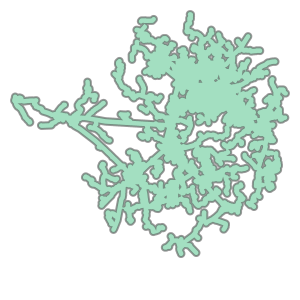

In [90]:
transmission_buff

In [93]:
transmission_buff_gdf = gpd.GeoDataFrame(geometry=[transmission_buff],
                                        crs=epsg)

In [95]:
transmission_buff_gdf

,geometry
0,"POLYGON ((183883.355 7524708.002, 183727.980 7..."


In [76]:
admin_proj = admin.to_crs(epsg)

In [97]:
admin_buff = gpd.overlay(admin_proj, transmission_buff_gdf, how='intersection')

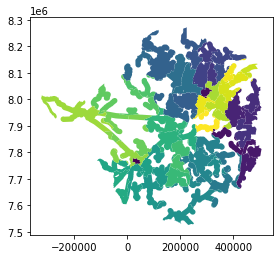

In [100]:
admin_buff.plot('OBJECTID')

In [102]:
admin_buff_wgs = admin_buff.to_crs('EPSG:4326')

In [107]:
zs_10k_trans_wp = pd.DataFrame(zonal_stats(admin_buff_wgs, wp_arr, affine=wp_100m.transform, stats='sum', nodata=wp_100m.nodata)).rename(columns={'sum':'pop_transmission_wp'})
zs_10k_trans_fb = pd.DataFrame(zonal_stats(admin_buff_wgs, fb_arr, affine=pop_fb.transform, stats='sum', nodata=pop_fb.nodata)).rename(columns={'sum':'pop_transmission_fb'})

In [108]:
res = pd.concat([admin, zs_sum_wp, zs_electrified_wp, zs_sum_fb, zs_electrified_fb, zs_10k_trans_wp, zs_10k_trans_fb], axis=1)
res['pct_access_wp'] = res['pop_electrified_wp']/res['pop_wp']
res['pct_access_fb'] = res['pop_electrified_fb']/res['pop_fb']
res['pct_transmission_10k_wp'] = res['pop_transmission_wp']/res['pop_wp']
res['pct_transmission_10k_fb'] = res['pop_transmission_fb']/res['pop_fb']
res.to_file(os.path.join(out_folder, "energy", "ElectricityAccess.shp"), driver='ESRI Shapefile')
res_table = res.drop(['geometry','Shape_Leng','Shape_Area'], axis=1)
res_table.to_csv(os.path.join(out_folder, "energy", "ElectricityAccess3.csv"), index=False)